<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*

---

# Análise dos Dados do Airbnb - Rio de Janeiro

O [Airbnb](https://www.airbnb.com.br/) já é considerado como sendo a **maior empresa hoteleira da atualidade**. Ah, o detalhe é que ele **não possui nenhum hotel**!

Conectando pessoas que querem viajar (e se hospedar) com anfitriões que querem alugar seus imóveis de maneira prática, o Airbnb fornece uma plataforma inovadora para tornar essa hospedagem alternativa.

No final de 2018, a Startup fundada 10 anos atrás, já havia **hospedado mais de 300 milhões** de pessoas ao redor de todo o mundo, desafiando as redes hoteleiras tradicionais.

Uma das iniciativas do Airbnb é disponibilizar dados do site, para algumas das principais cidades do mundo. Por meio do portal [Inside Airbnb](http://insideairbnb.com/get-the-data.html), é possível baixar uma grande quantidade de dados para desenvolver projetos e soluções de *Data Science*.

<center><img alt="Analisando Airbnb" width="10%" src="https://www.area360.com.au/wp-content/uploads/2017/09/airbnb-logo.jpg"></center>

**Neste *notebook*, iremos analisar os dados referentes à cidade do Rio de Janeiro, e ver quais insights podem ser extraídos a partir de dados brutos.**

## Obtenção dos Dados

Todos os dados usados aqui foram obtidos a partir do site [Inside Airbnb](http://insideairbnb.com/get-the-data.html).

Para esta análise exploratória inicial, será baixado apenas o seguinte arquivo:

* `listings.csv.gz` 


In [ ]:
# importar os pacotes necessarios
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# importar o arquivo listings.csv para um DataFrame
df = pd.read_csv("http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2022-12-29/data/listings.csv.gz")


In [ ]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Selecionaremos algumas características consideradas mais importantes para modelagens assim como faixa de valores condizentes com a vida real. O número de pessoas acomodadas, quantidade de banheiros, quartos e camas, preço, localização e nota serão considerados.

In [ ]:
df_clean = df[["id","reviews_per_month","host_is_superhost","neighbourhood_cleansed","room_type","accommodates","bathrooms_text","bedrooms","beds","amenities","price","review_scores_rating","number_of_reviews","latitude","longitude","minimum_nights"]].copy()

Queremos considerar locações com quantidade suficiente de dados e com notas mais positivas para a análise dos dados. Logo, eliminamos locações que não sejam casas e apartamentos completos ou com notas baixas ou com poucos reviews.

In [ ]:
df_clean.drop(df_clean[df_clean.room_type != "Entire home/apt"].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.number_of_reviews < 5].index, axis=0, inplace=True)
df_clean.drop(df_clean[df_clean.review_scores_rating < 4].index, axis=0, inplace=True)

Adaptaremos os dados para facilitar análise.

In [ ]:
df_clean.host_is_superhost.fillna("f",inplace = True)
df_clean.reset_index(inplace = True)   
for i in range(len(df_clean)):
  
  if df_clean.host_is_superhost[i] == str("t"): # converteremos o fato de ser super host para um valor numérico.
    df_clean.host_is_superhost[i] = float(1.)
  else:
    df_clean.host_is_superhost[i] = float(0.)


In [ ]:
for i in range(len(df_clean)):
#determina quantidade de banheiros.
  if df_clean.bathrooms_text[i] == "Half-bath":   
    df_clean.bathrooms_text[i] = 0.5   
  elif type(df_clean.bathrooms_text[i]) != float:
    df_clean.bathrooms_text[i] = float(df_clean.bathrooms_text[i][:2])

In [ ]:
for i in range(len(df_clean)):
  if type(df_clean.price[i]) != float:           #transforma o preço para float.
    df_clean.price[i] = float(df_clean.price[i][1:].replace(",",""))

In [ ]:
df_clean["kitchen"] = 0.  # aqui, criaremos novas condições, como cozinha, ar condicionado, tv e wifi.
df_clean["air_cond"] = 0.
df_clean["TV"] = 0.
df_clean["wifi"] = 0.

for i in range(len(df_clean)):

  amenitie = df_clean.amenities[i].lower()

  if "air conditioning" in amenitie:
    df_clean.air_cond[i] = 1.
  
  if "tv" in amenitie:
    df_clean.TV = 1.
  
  if "kitchen" in amenitie:
    df_clean.kitchen[i] = 1.

  
  if "wifi" in amenitie:
    df_clean.wifi[i] = 1.
  
  if "wi fi" in amenitie:
    df_clean.wifi[i] = 1.


In [ ]:
df_clean.host_is_superhost = df_clean.host_is_superhost.astype(float)
df_clean.bathrooms_text = df_clean.bathrooms_text.astype(float)
df_clean.price = df_clean.price.astype(float)

In [ ]:
df_clean.dropna(inplace = True)

Agora, associaremos o bairro ao valor de seu metro quadrado. Dados a partir do link: https://portal.loft.com.br/metro-quadrado-mais-caro-do-rio-de-janeiro/

In [ ]:
data  = { "Leblon"	:  16928, "Ipanema"	: 15328, "Lagoa" : 15249, "Jardim Botânico" : 14530, "Gávea" : 	14078, "Urca" : 13083, "Botafogo"	: 12513, "Humaitá" : 12402,	
"Barra Da Tijuca: Jardim Oceânico" : 12042, "Leme" : 11408, "Barra Da Tijuca" : 11038, "Copacabana" : 10955, "Flamengo" : 10671,"Laranjeiras": 10438,"São Conrado" : 10402,
"Glória" :  9716,"Catete" : 9550,"Cosme Velho" : 9530, "Paciência" :	9122,"Guaratiba" : 8538,"Gamboa": 8083,"Santa Cruz"	: 8070,"Cidade Nova"	: 7941 ,"Jacarepaguá"	: 7904,
"Santo Cristo"	:  7890,	"Centro" : 7881, "Itanhangá" : 7710, "Alto Da Boa Vista":	 7676, "Recreio Dos Bandeirantes" : 7509, "Maracanã"	: 7443,"Santa Teresa" : 7215,
"Campo Grande" : 7105, "Tijuca" : 7052,	"Ribeira (Ilha Do Governador)" : 7045, "Camorim" : 6833 }
data2 = {}
for i in data:
 data2[i.lower()] = data[i]
df_clean["valor"] = 0
df_clean.reset_index(drop = True, inplace =True)
for i in range((len(df_clean))):
  if df_clean.neighbourhood_cleansed[i].lower() in data2:
   df_clean["valor"][i] = data2[df_clean.neighbourhood_cleansed[i].lower()]
  else:
    df_clean.drop([i],axis = 0,inplace = True)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9168 entries, 0 to 9602
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   9168 non-null   int64  
 1   id                      9168 non-null   int64  
 2   reviews_per_month       9168 non-null   float64
 3   host_is_superhost       9168 non-null   float64
 4   neighbourhood_cleansed  9168 non-null   object 
 5   room_type               9168 non-null   object 
 6   accommodates            9168 non-null   int64  
 7   bathrooms_text          9168 non-null   float64
 8   bedrooms                9168 non-null   float64
 9   beds                    9168 non-null   float64
 10  amenities               9168 non-null   object 
 11  price                   9168 non-null   float64
 12  review_scores_rating    9168 non-null   float64
 13  number_of_reviews       9168 non-null   int64  
 14  latitude                9168 non-null   

In [ ]:
df_clean.describe()

,index,id,reviews_per_month,host_is_superhost,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,latitude,longitude,minimum_nights,kitchen,air_cond,TV,wifi,valor
count,9168.000000,9.168000e+03,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.0,9168.000000,9168.000000
mean,13442.389943,9.928258e+16,1.215513,0.400305,4.438373,1.518652,1.689245,2.745201,1202.641470,4.805776,38.405868,-22.974195,-43.235938,3.765816,0.964005,0.583661,1.0,0.974149,11542.517125
std,7775.698275,2.316522e+17,1.130564,0.489987,2.121055,0.832308,0.902565,1.781289,5062.609522,0.194729,48.803832,0.025410,0.089568,17.317082,0.186287,0.492978,0.0,0.158699,2681.053754
min,3.000000,1.787800e+04,0.040000,0.000000,1.000000,0.000000,1.000000,1.000000,61.000000,4.000000,5.000000,-23.063370,-43.677920,1.000000,0.000000,0.000000,1.0,0.000000,6833.000000
25%,6772.500000,1.366818e+07,0.370000,0.000000,3.000000,1.000000,1.000000,2.000000,421.000000,4.710000,10.000000,-22.985041,-43.225143,2.000000,1.000000,0.000000,1.0,1.000000,10955.000000
50%,13102.500000,3.710526e+07,0.880000,0.000000,4.000000,1.000000,1.000000,2.000000,686.000000,4.860000,20.000000,-22.976750,-43.192365,2.000000,1.000000,1.000000,1.0,1.000000,10955.000000
75%,19333.500000,5.250736e+07,1.700000,1.000000,5.000000,2.000000,2.000000,3.000000,1093.000000,4.960000,46.000000,-22.964670,-43.184807,3.000000,1.000000,1.000000,1.0,1.000000,12513.000000
max,28297.000000,7.768670e+17,12.000000,1.000000,16.000000,15.000000,10.000000,25.000000,225651.000000,5.000000,548.000000,-22.859390,-43.159970,999.000000,1.000000,1.000000,1.0,1.000000,16928.000000


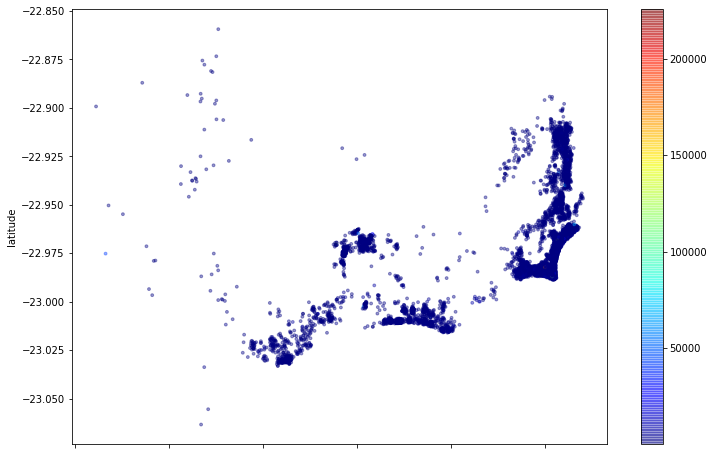

In [ ]:
df_clean.plot(kind="scatter", x='longitude', y='latitude', alpha=0.4, c=df_clean['price'], s=8,
              cmap=plt.get_cmap('jet'), figsize=(12,8));

## Análise dos Dados

Esta etapa tem por objetivo criar uma consciência situacional inicial e permitir um entendimento de como os dados estão estruturados.


**Dicionário das variáveis**

* `id` - número de id gerado para identificar o imóvel
* `host_is_superhost`- categoria a qual o host pertence
* `neighbourhood_cleansed` - nome do bairro
* `latitude` - coordenada da latitude da propriedade
* `longitude` - coordenada da longitude da propriedade
* `room_type` - informa o tipo de quarto que é oferecido
* `price` - preço para alugar o imóvel
* `minimum_nights` - quantidade mínima de noites para reservar
* `number_of_reviews` - número de reviews que a propriedade possui
* `accommodates` - quantas pessoas a casa acomoda
* `bathrooms_text` - quantidade de banheiros
* `beds` - quantidade de camas
* `bedrooms` - quantidade de quartos
* `amenities` - extras da locação
* `kitchen, air_cond,tv,wifi` - Dados sobre presença de cozinha, ar condicionado, TV e wifi
* `valor` - valor do metro quadrado do bairro 


Antes de iniciar qualquer análise, vamos verificar a cara do nosso *dataset*, analisando as 5 primeiras entradas.

In [ ]:
# mostrar as 5 primeiras entradas
df_clean.head()

,index,id,reviews_per_month,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds,...,review_scores_rating,number_of_reviews,latitude,longitude,minimum_nights,kitchen,air_cond,TV,wifi,valor
0,3,23768085,1.59,0.0,Barra da Tijuca,Entire home/apt,2,1.0,1.0,6.0,...,4.79,92,-23.01104,-43.32034,3,1.0,1.0,1.0,1.0,11038
1,12,3147066,2.94,1.0,Ipanema,Entire home/apt,4,1.0,2.0,2.0,...,4.91,307,-22.98113,-43.19848,2,1.0,0.0,1.0,1.0,15328
2,19,13129278,0.37,0.0,Barra da Tijuca,Entire home/apt,6,4.0,3.0,3.0,...,4.93,29,-23.01887,-43.44984,25,1.0,1.0,1.0,1.0,11038
3,22,43851003,0.70,0.0,Ipanema,Entire home/apt,4,1.0,2.0,3.0,...,4.17,18,-22.98103,-43.19816,1,0.0,1.0,1.0,1.0,15328
4,38,47937561,0.35,0.0,Ipanema,Entire home/apt,6,1.0,2.0,3.0,...,4.88,8,-22.98406,-43.20392,5,0.0,1.0,1.0,1.0,15328


### **Q1. Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Vamos prosseguir e identificar a quantidade de entradas que nosso conjunto de dados possui e ver os tipos de cada coluna.


In [ ]:
# identificar o volume de dados do DataFrame
print("Entradas:\t {}".format(df_clean.shape[0]))
print("Variáveis:\t {}\n".format(df_clean.shape[1]))

# verificar as 5 primeiras entradas do dataset
display(df_clean.dtypes)

Entradas:	 9168
Variáveis:	 22



index                       int64
id                          int64
reviews_per_month         float64
host_is_superhost         float64
neighbourhood_cleansed     object
room_type                  object
accommodates                int64
bathrooms_text            float64
bedrooms                  float64
beds                      float64
amenities                  object
price                     float64
review_scores_rating      float64
number_of_reviews           int64
latitude                  float64
longitude                 float64
minimum_nights              int64
kitchen                   float64
air_cond                  float64
TV                        float64
wifi                      float64
valor                       int64
dtype: object

### **Q2. Qual a porcentagem de valores ausentes no *dataset*?**

A qualidade de um *dataset* está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas.

Como os dados já foram tratados na seção anterior, não haverá valores nulos.

In [ ]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(df_clean.isnull().sum() / df_clean.shape[0]).sort_values(ascending=False)

index                     0.0
id                        0.0
wifi                      0.0
TV                        0.0
air_cond                  0.0
kitchen                   0.0
minimum_nights            0.0
longitude                 0.0
latitude                  0.0
number_of_reviews         0.0
review_scores_rating      0.0
price                     0.0
amenities                 0.0
beds                      0.0
bedrooms                  0.0
bathrooms_text            0.0
accommodates              0.0
room_type                 0.0
neighbourhood_cleansed    0.0
host_is_superhost         0.0
reviews_per_month         0.0
valor                     0.0
dtype: float64

### **Q3. Qual o tipo de distribuição das variáveis?** 

Para identificar a distribuição das variáveis, irei plotar o histograma.

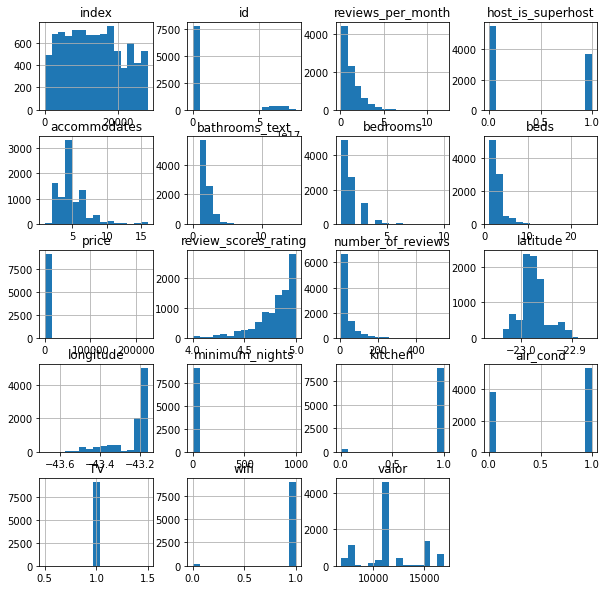

In [ ]:
# plotar o histograma das variáveis numéricas
df_clean.hist(bins=15, figsize=(10,10));

### **Q4. Há *outliers* presentes?**

Pela distribuição do histograma, é possível verificar indícios da presença de *outliers*. Olhe por exemplo as variáveis `price`e `minimum_nights`
Os valores não seguem uma distruição, e distorcem toda a representação gráfica. Para confirmar, há duas maneiras rápidas que auxiliam a detecção de *outliers*. São elas:

* Resumo estatístico por meio do método `describe()`
* Plotar `boxplots` para a variável.

In [ ]:
# ver o resumo estatístico das variáveis numéricas
df_clean.describe()

,index,id,reviews_per_month,host_is_superhost,accommodates,bathrooms_text,bedrooms,beds,price,review_scores_rating,number_of_reviews,latitude,longitude,minimum_nights,kitchen,air_cond,TV,wifi,valor
count,9168.000000,9.168000e+03,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.0,9168.000000,9168.000000
mean,13442.389943,9.928258e+16,1.215513,0.400305,4.438373,1.518652,1.689245,2.745201,1202.641470,4.805776,38.405868,-22.974195,-43.235938,3.765816,0.964005,0.583661,1.0,0.974149,11542.517125
std,7775.698275,2.316522e+17,1.130564,0.489987,2.121055,0.832308,0.902565,1.781289,5062.609522,0.194729,48.803832,0.025410,0.089568,17.317082,0.186287,0.492978,0.0,0.158699,2681.053754
min,3.000000,1.787800e+04,0.040000,0.000000,1.000000,0.000000,1.000000,1.000000,61.000000,4.000000,5.000000,-23.063370,-43.677920,1.000000,0.000000,0.000000,1.0,0.000000,6833.000000
25%,6772.500000,1.366818e+07,0.370000,0.000000,3.000000,1.000000,1.000000,2.000000,421.000000,4.710000,10.000000,-22.985041,-43.225143,2.000000,1.000000,0.000000,1.0,1.000000,10955.000000
50%,13102.500000,3.710526e+07,0.880000,0.000000,4.000000,1.000000,1.000000,2.000000,686.000000,4.860000,20.000000,-22.976750,-43.192365,2.000000,1.000000,1.000000,1.0,1.000000,10955.000000
75%,19333.500000,5.250736e+07,1.700000,1.000000,5.000000,2.000000,2.000000,3.000000,1093.000000,4.960000,46.000000,-22.964670,-43.184807,3.000000,1.000000,1.000000,1.0,1.000000,12513.000000
max,28297.000000,7.768670e+17,12.000000,1.000000,16.000000,15.000000,10.000000,25.000000,225651.000000,5.000000,548.000000,-22.859390,-43.159970,999.000000,1.000000,1.000000,1.0,1.000000,16928.000000


Olhando o resumo estatístico acima, podemos confirmar algumas hipóteses como:

* A variável `price` possui 75% do valor abaixo de 421, porém seu valor máximo é 225651.
* A quantidade mínima de noites (`minimum_nights`) está acima de 365 dias no ano.

#### Boxplot para minimum_nights


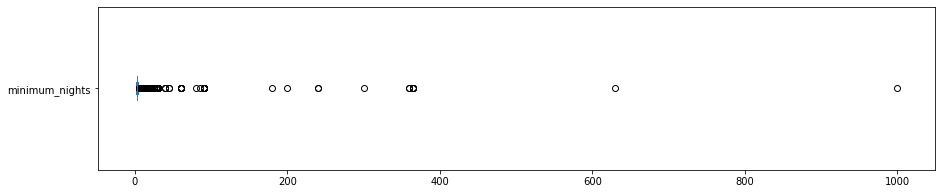


price: valores acima de 15
111 entradas
1.2107%


In [ ]:
# minimum_nights
df_clean.minimum_nights.plot(kind='box', vert=False, figsize=(15, 3),)
plt.show()

# ver quantidade de valores acima de 15 para minimum_nights
print("\nprice: valores acima de 15")
print("{} entradas".format(len(df_clean[df_clean.minimum_nights > 15])))
print("{:.4f}%".format((len(df_clean[df_clean.minimum_nights > 15]) / df_clean.shape[0])*100))

# df.price.plot(kind='box', vert=False, xlim=(0,1300), figsize=(15,3));

#### Boxplot para price

In [ ]:
df_clean.price

0        494.0
1       1403.0
2        585.0
3        782.0
4       1057.0
         ...  
9598     913.0
9599    1500.0
9600    1200.0
9601     135.0
9602     194.0
Name: price, Length: 9168, dtype: float64

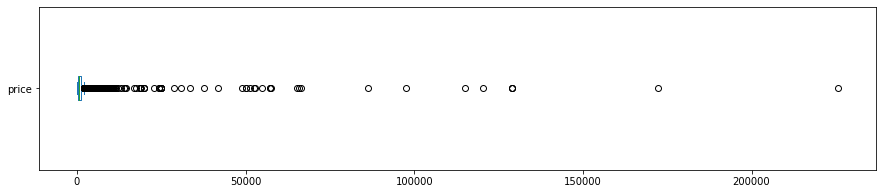


price: valores acima de 3000
334 entradas
3.6431%


In [ ]:
# price
df_clean.price.plot(kind='box', vert=False, figsize=(15, 3),)
plt.show()

# ver quantidade de valores acima de 3000 para price
print("\nprice: valores acima de 3000")
print("{} entradas".format(len(df_clean[df_clean.price > 3000])))
print("{:.4f}%".format((len(df_clean[df_clean.price > 3000]) / df_clean.shape[0])*100))

# df.price.plot(kind='box', vert=False, xlim=(0,1300), figsize=(15,3));

#### Boxplot para beds

In [ ]:
df_clean.beds

0       6.0
1       2.0
2       3.0
3       3.0
4       3.0
       ... 
9598    3.0
9599    1.0
9600    5.0
9601    1.0
9602    1.0
Name: beds, Length: 9168, dtype: float64

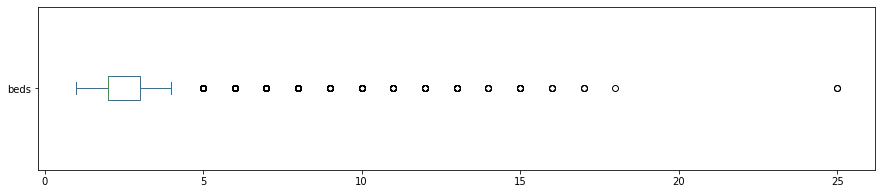


price: valores acima de 8
115 entradas
1.2544%


In [ ]:
# beds
df_clean.beds.plot(kind='box', vert=False, figsize=(15, 3),)
plt.show()

# ver quantidade de valores acima de 8 para beds
print("\nprice: valores acima de 8")
print("{} entradas".format(len(df_clean[df_clean.beds> 8])))
print("{:.4f}%".format((len(df_clean[df_clean.beds > 8]) / df_clean.shape[0])*100))

# df.price.plot(kind='box', vert=False, xlim=(0,1300), figsize=(15,3));

#### Boxplot para accommodates

In [ ]:
df_clean.accommodates

0       2
1       4
2       6
3       4
4       6
       ..
9598    6
9599    2
9600    5
9601    2
9602    2
Name: accommodates, Length: 9168, dtype: int64

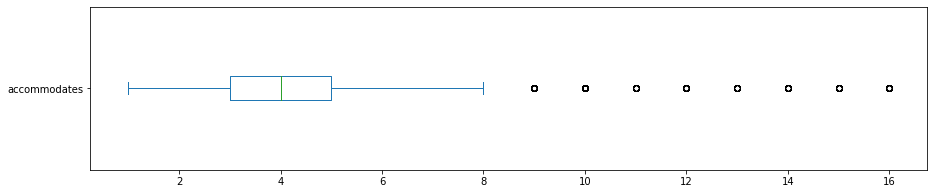


price: valores acima de 10
157 entradas
1.7125%


In [ ]:
# accommodates
df_clean.accommodates.plot(kind='box', vert=False, figsize=(15, 3),)
plt.show()

# ver quantidade de valores acima de 10 para accommodates
print("\nprice: valores acima de 10")
print("{} entradas".format(len(df_clean[df_clean.accommodates> 10])))
print("{:.4f}%".format((len(df_clean[df_clean.accommodates > 10]) / df_clean.shape[0])*100))

# df.price.plot(kind='box', vert=False, xlim=(0,1300), figsize=(15,3));

#### Histogramas sem *outliers*

Já que identificamos *outliers* nas variáveis `price` e `minimum_nights`, vamos agora limpar o *DataFrame* delas e plotar novamente o histograma.

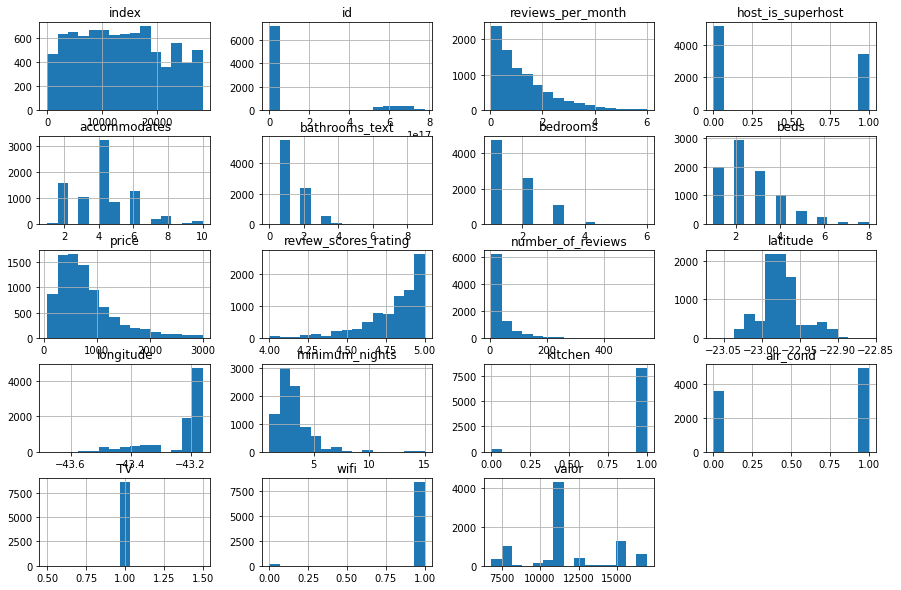

In [ ]:
# remover os *outliers* em um novo DataFrame
df_clean2 = df_clean.copy()
df_clean2.drop(df_clean2[df_clean2.price > 3000].index, axis=0, inplace=True)
df_clean2.drop(df_clean2[df_clean2.minimum_nights > 15].index, axis=0, inplace=True)
df_clean2.drop(df_clean2[df_clean2.accommodates > 10].index, axis=0, inplace=True)
df_clean2.drop(df_clean2[df_clean2.beds > 8].index, axis=0, inplace=True)
df_clean2.drop(df_clean2[df_clean2.beds > 8].index, axis=0, inplace=True)
df_clean2.drop(df_clean2[df_clean2.reviews_per_month > 6].index, axis=0, inplace=True)

# plotar o histograma para as variáveis numéricas
df_clean2.hist(bins=15, figsize=(15,10));

### **Q4. Qual a correlação existente entre as variáveis**

Correlação significa que existe uma relação entre duas coisas. No nosso contexto, estamos buscando relação ou semelhança entre duas variáveis.

Essa relação pode ser medida, e é função do coeficiente de correlação estabelecer qual a intensidade dela. Para identificar as correlações existentes entre as variáveis de interesse, vou:

* Criar uma matriz de correlação
* Gerar um *heatmap* a partir dessa matriz, usando a biblioteca `seaborn`

In [ ]:
# criar uma matriz de correlação
corr = df_clean2[['price', 'reviews_per_month','minimum_nights', 'number_of_reviews', "accommodates" ,"bathrooms_text", "bedrooms","beds","review_scores_rating","air_cond","valor"]].corr()

display(corr)

,price,reviews_per_month,minimum_nights,number_of_reviews,accommodates,bathrooms_text,bedrooms,beds,review_scores_rating,air_cond,valor
price,1.000000,-0.024231,-0.051760,-0.012046,0.421475,0.426300,0.460635,0.337675,-0.008854,0.041000,0.337038
reviews_per_month,-0.024231,1.000000,-0.265368,0.393616,-0.054566,-0.136776,-0.163174,-0.094370,0.119500,-0.141345,-0.006713
minimum_nights,-0.051760,-0.265368,1.000000,-0.050596,-0.073369,0.030145,0.024880,-0.015696,0.020677,0.025498,0.040718
number_of_reviews,-0.012046,0.393616,-0.050596,1.000000,0.002141,-0.059821,-0.071287,0.001733,0.007044,-0.003167,0.060766
accommodates,0.421475,-0.054566,-0.073369,0.002141,1.000000,0.560056,0.713632,0.741663,-0.014165,0.010635,0.002664
bathrooms_text,0.426300,-0.136776,0.030145,-0.059821,0.560056,1.000000,0.729322,0.502246,0.053982,0.042285,0.080039
bedrooms,0.460635,-0.163174,0.024880,-0.071287,0.713632,0.729322,1.000000,0.671172,0.037881,0.027774,0.064027
beds,0.337675,-0.094370,-0.015696,0.001733,0.741663,0.502246,0.671172,1.000000,0.002198,0.008356,0.008154
review_scores_rating,-0.008854,0.119500,0.020677,0.007044,-0.014165,0.053982,0.037881,0.002198,1.000000,-0.078222,-0.022233
air_cond,0.041000,-0.141345,0.025498,-0.003167,0.010635,0.042285,0.027774,0.008356,-0.078222,1.000000,0.075660


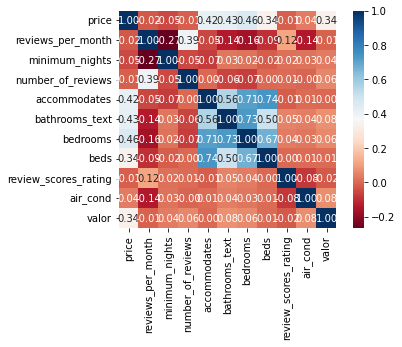

In [ ]:
sns.heatmap(corr, cmap='RdBu', fmt='.2f', square=True, linecolor='white', annot=True);

### **Q6. Qual a localidade mais cara do Rio?**

Uma maneira de se verificar uma variável em função da outra é usando `groupby()`. No caso, queremos comparar os bairros (*neighbourhoods*) a partir do preço de locação.

In [ ]:
df_clean2.groupby(['neighbourhood_cleansed']).price.mean().sort_values(ascending=False)[:10]

neighbourhood_cleansed
Leblon               1157.978333
Ipanema              1090.482412
São Conrado          1063.214286
Lagoa                 940.000000
Gávea                 916.687500
Alto da Boa Vista     905.888889
Barra da Tijuca       852.118717
Leme                  848.852941
Copacabana            791.888924
Jardim Botânico       721.352941
Name: price, dtype: float64

Como são fornecidas as Latitudes e Longitudes para os imóveis, é possível plotar cada ponto. Para isso, considera-se `x=longitude` e `y=latitude`.

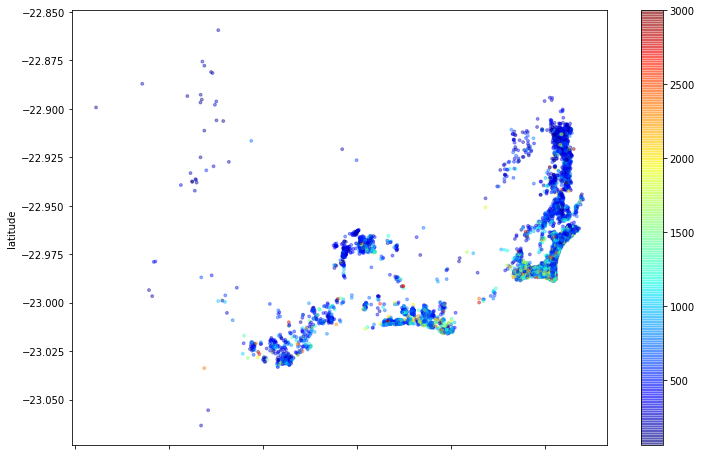

In [ ]:
# plotar os imóveis pela latitude-longitude
df_clean2.plot(kind="scatter", x='longitude', y='latitude', alpha=0.4, c=df_clean2['price'], s=8,
              cmap=plt.get_cmap('jet'), figsize=(12,8));

## Conclusões

Foi feita apenas uma análise superficial na base de dados do Airbnb, porém já se percebeu que existem *outliers* em algumas das variáveis. 

Também se notou que em algumas localidades há poucos imóveis disponíveis, o que pode distorcer as informações estatísticas de alguns atributos.

A análise demonstrou uma alta correlação linear entre quantidade de camas, quartos, banheiros e pessoas acomodadas,o valor do metro quadrado na região e o valor da locação, como se era de esperar.

É possível com estes dados estimar o preço de locação da casa. É uma ferramenta bastante importante para interessados em fornecer sua casa ou alugar uma e não sabem qual preço ideal.

Importante ressaltar que pela política de dados da empresa, a análise está incompleta. Reduzimos a quantidade de outliers considerando casas com pouquíssimas locações, porém não conseguimos estimar quais casas possuem maior taxa de locação - um dado sensível e importante ao predizer um valor de uma casa.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
X = np.array(df_clean2[["host_is_superhost","accommodates","bathrooms_text","review_scores_rating","bedrooms","beds","latitude","longitude","air_cond","valor","number_of_reviews","reviews_per_month"]])
Y = np.array(df_clean2["price"])

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2)
df_imputer = SimpleImputer()
train_X = df_imputer.fit_transform(train_X)
test_X = df_imputer.transform(test_X)

Os algoritmos testados serão XGBoost e RandomForest.

In [ ]:
param_grid = [{'max_depth': np.arange(3,10), 'n_estimators': np.arange(100,130,4),'learning_rate' : np.linspace(0.01,0.1,5)}]
model = XGBRegressor()
grid_search = GridSearchCV(model,param_grid,cv = 5)
# chamar o fit para o modelo
grid_search.fit(X, Y)
grid_search.best_params_

{'learning_rate': 0.0775, 'max_depth': 4, 'n_estimators': 116}

In [ ]:
model = XGBRegressor(max_depth = 4,n_estimators = 116,learning_rate = 0.0775)
# chamar o fit para o modelo
model.fit(train_X, train_y, verbose=False)
# fazer previsões em cima do dataset de teste
predictions = model.predict(test_X)
print("Erro Relativo Absoluto: {:.2f}".format(mean_absolute_percentage_error(predictions, test_y)))
print("Erro Relativo Absoluto: {:.2f}".format(mean_absolute_percentage_error(model.predict(train_X), train_y)))

[21:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Erro Relativo Absoluto: 0.38
Erro Relativo Absoluto: 0.35


In [ ]:
param_grid = [{'max_leaf_nodes': [20,600], 'n_estimators': [500,1000]}]
model2 = RandomForestRegressor()
grid_search = GridSearchCV(model2,param_grid,cv = 5)
# chamar o fit para o modelo
grid_search.fit(X, Y)




GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_leaf_nodes': [20, 600],
                          'n_estimators': [500, 1000]}])

In [ ]:
grid_search.best_params_

{'max_leaf_nodes': 600, 'n_estimators': 1000}

In [ ]:
 rnd_reg = RandomForestRegressor(max_leaf_nodes = 600,n_estimators = 1000)
 rnd_reg.fit(train_X,train_y)
 predictions = rnd_reg.predict(test_X)
 print("Erro Relativo Absoluto: {:.2f}".format(mean_absolute_percentage_error(predictions, test_y)))
 print("Erro Relativo Absoluto: {:.2f}".format(mean_absolute_percentage_error(rnd_reg.predict(train_X), train_y)))


Erro Relativo Absoluto: 0.38
Erro Relativo Absoluto: 0.26


Ambos métodos apresentaram resultados semelhantes, com cerca de 38% de erro nos casos de teste. É uma precisão já considerável pois dados sobre taxa de locação estão indisponíveis. Caso estivessem disponíveis, seria possível gerar um algoritmo que estima o preço ideal que maximiza o lucro mensal, e não o preço que acompanha as tendências do mercado somente.

* Observação: Ainda que grid_search do RandomForestGenerator aponte como ideal valores limites do intervalo de estudo - o que indica a necessidade de teste de mais casos fora deste intervalo -, o aumento dos casos somente diminui o erro sobre casos de treino, mantendo-se estável em casos de teste.


